**Loading Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "drive/My Drive/ZIP_FILES/archivescape.zip" -d "Dataset" | head -n 5

# **Importing Libraries**

In [ ]:
import torch
import datetime
from matplotlib.pyplot import imshow, imsave
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from PIL import Image
import numpy as np

In [ ]:
from PIL import Image
import os

def is_grayscale(image_path):
    img = Image.open(image_path)
    return img.mode == 'L'  # 'L' indicates grayscale mode in PIL

# Replace 'your_dataset_folder' with the path to your dataset folder
dataset_folder = 'Dataset'
grayscale_images = []

for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        image_path = os.path.join(root, file)
        if is_grayscale(image_path):
            grayscale_images.append(image_path)

print(f"Number of grayscale images: {len(grayscale_images)}")
print(grayscale_images)

Number of grayscale images: 3
['Dataset/00000172_(6).jpg', 'Dataset/00000692_(2).jpg', 'Dataset/00000356_(5).jpg']


# **Importing Python files**

In [ ]:
from modelDCGAN import Discriminator, Generator
from dataloader import SCAPE

# Model Configuration

In [ ]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
IMAGE_DIM = (32, 32, 3)
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(10, n_noise).to(DEVICE)
    y_hat = G(z).view(10, 3, 32, 32).permute(0, 2, 3, 1) # (100, 28, 28)
    result = (y_hat.detach().cpu().numpy()+1)/2.
    return result


# Initialize models
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)#Load discriminator
G = Generator(out_channel=IMAGE_DIM[-1]).to(DEVICE)# Load generator

# Modify normalization parameters for grayscale images
transform = transforms.Compose([
    transforms.Resize((IMAGE_DIM[0], IMAGE_DIM[1])),
    transforms.Grayscale(num_output_channels=3),  # Convert images to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalization for grayscale images
])


In [ ]:
dataset = CARS(data_path='Dataset', transform=transform)#Load images

batch_size = 64



data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True,num_workers=0)


criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))


max_epoch = 100
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100


In [ ]:

D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake
D_losses = []
G_losses = []
epochs = []

# **Training the model**

In [ ]:
for epoch in range(max_epoch):
    for idx, images in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step > 0:
            D_losses.append(D_loss.item())
            epochs.append(epoch)
            G_losses.append(G_loss.item())

        if step % 500 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, Time:{}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), dt))
            G.eval()
            img = get_sample_image(G, n_noise)
            # create folder by right clicking in the file window and name the folder 'samples'
            #imsave('content/samples/{}_step{:05d}.jpg'.format(MODEL_NAME, step), img[0])
            G.train()
        step += 1

Epoch: 0/100, Step: 0, D Loss: 1.4035, G Loss: 0.7958, Time:17:40:58
Epoch: 7/100, Step: 500, D Loss: 1.1250, G Loss: 1.0483, Time:17:46:56
Epoch: 14/100, Step: 1000, D Loss: 1.1888, G Loss: 1.2059, Time:17:52:55
Epoch: 22/100, Step: 1500, D Loss: 1.3541, G Loss: 1.1761, Time:17:58:52
Epoch: 29/100, Step: 2000, D Loss: 1.3241, G Loss: 1.6651, Time:18:04:49
Epoch: 37/100, Step: 2500, D Loss: 1.0629, G Loss: 1.6186, Time:18:10:45
Epoch: 44/100, Step: 3000, D Loss: 0.9378, G Loss: 1.6667, Time:18:16:42
Epoch: 52/100, Step: 3500, D Loss: 0.7871, G Loss: 1.1035, Time:18:22:40
Epoch: 59/100, Step: 4000, D Loss: 0.9157, G Loss: 1.4808, Time:18:28:35
Epoch: 67/100, Step: 4500, D Loss: 0.7655, G Loss: 2.0611, Time:18:34:30
Epoch: 74/100, Step: 5000, D Loss: 0.7725, G Loss: 1.3141, Time:18:40:24
Epoch: 82/100, Step: 5500, D Loss: 1.0712, G Loss: 1.0220, Time:18:46:17
Epoch: 89/100, Step: 6000, D Loss: 1.1083, G Loss: 2.5071, Time:18:52:11
Epoch: 97/100, Step: 6500, D Loss: 0.7323, G Loss: 1.3734

# Plotting results

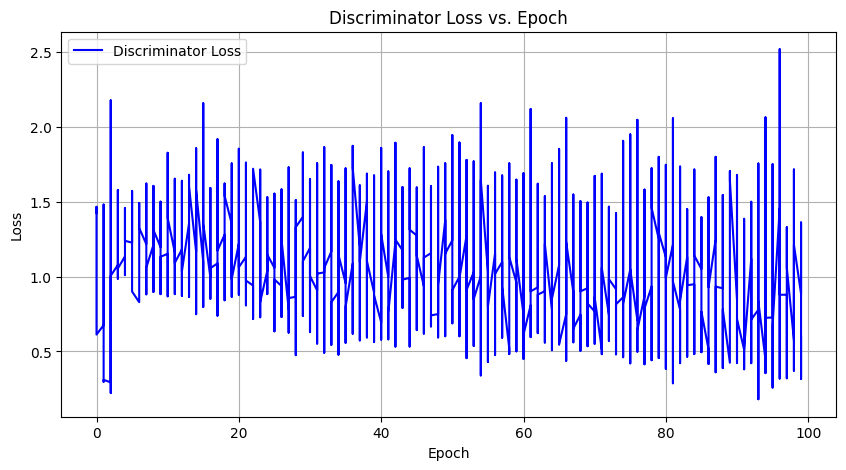

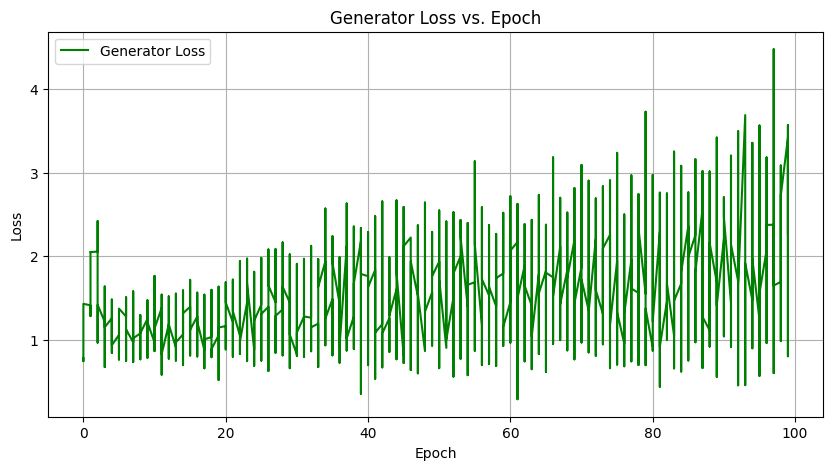

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have D_losses, G_losses, and epochs lists after training

# Plot Discriminator loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, D_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot Generator loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, G_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


# Generator Image

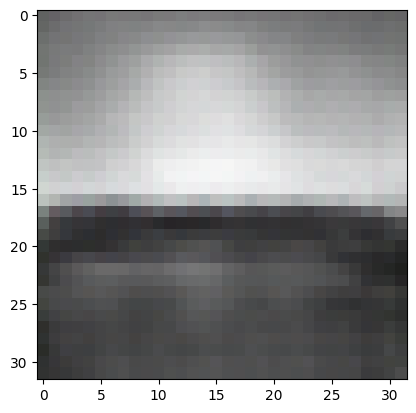

In [ ]:
G.eval()
imshow(get_sample_image(G, n_noise)[8]) #Generator image

# Sample Image from dataset

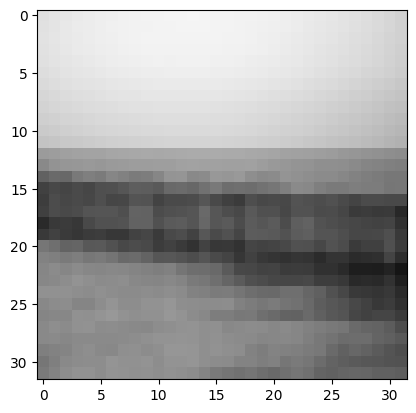

In [ ]:
t = Image.open(dataset.fpaths[2110])#random sample image from dataset
t = (transform(t).permute(1, 2, 0)+1)/2.
imshow(t)

